https://www.iartificial.net/precision-recall-f1-accuracy-en-clasificacion/

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../../src')

In [3]:
import matplotlib.pyplot as plt
import seaborn           as sns
from scipy import interpolate

import numpy             as np
import pandas            as pd

from bunch import Bunch

import metrics as mt
import plot as pl

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
DATASET_PATH      = '../../datasets/fashion-outfits'
MODEL_RESULT_PATH = f'{DATASET_PATH}/:model-pred-target.csv'
MODEL_NAMES       = [
    'bayes-unigrams',
    'lstm-bigrams',
    'lstm-unigrams',
    'ff-unigrams_emb',
    'ff-w2v_avg',
    'ff-tfidf_svd',
    'bert',
    'ensamble'
]

In [6]:
def save_report(report):
    report \
        .drop_duplicates() \
        .sort_values(by=['model']) \
        .to_csv(f'{DATASET_PATH}/clasification_report.csv',  index=False)

In [7]:
def intersection(lists):
    return set(lists[0]).intersection(*lists[1:])

def models_classes(report):
    model_and_class = report \
        .groupby(['model', 'class'])['support'] \
        .count() \
        .reset_index(name='count') \
        [['model', 'class']]

    sets = []
    for model in model_and_class['model'].values:
        sets.append(set(model_and_class[model_and_class['model'] == model]['class'].values))

    return sets

def models_common_classes(report): return intersection(models_classes(report))

In [8]:
def plot_summary(report, *metrics):
    [pl.comparative_box_plot(report, m, 'model') for m in metrics]

In [9]:
def upper_outliers_level(df, column):
    values = df[column].values
    q1     = np.quantile(values, 0.25)
    q3     = np.quantile(values, 0.75)
    return (q3-q1) * 1.5

In [10]:
def load_results(path, model_names):
    return Bunch({model:pd.read_csv(path.replace(':model', model)) for model in model_names})

In [ ]:
BETA=0.5

model_results = load_results(MODEL_RESULT_PATH, MODEL_NAMES)
report        = mt.MultiClassicationReportGenerator().generate(model_results, beta=BETA)

save_report(report)

In [38]:
metrics_totals = report \
    .groupby('model') \
    .aggregate({'precision':'mean', 'recall': 'mean', 'f1-score': 'mean', f'f{BETA}-score': 'mean'}) \
    .sort_values(by=[f'f{BETA}-score'], ascending=False)

metrics_totals.round(2)

,precision,recall,f1-score,f0.6-score
model,,,,
ensamble,0.73,0.70,0.70,0.74
lstm-unigrams,0.71,0.65,0.67,0.72
bert,0.69,0.73,0.70,0.71
ff-unigrams_emb,0.70,0.66,0.66,0.70
ff-tfidf_svd,0.67,0.63,0.64,0.69
lstm-bigrams,0.68,0.63,0.64,0.69
ff-w2v_avg,0.66,0.59,0.61,0.68
bayes-unigrams,0.63,0.51,0.53,0.58


In [13]:
order_criterion = { model: index for index, model in enumerate(metrics_totals.index.values) }
order_criterion

report['order'] = report['model'].apply(lambda x: order_criterion[x])

report = report.sort_values(by=['order']).drop(columns=['order'])

## Comparativa para clases en común a todos los modelos

### Comparativa de distribuciones

In [14]:
common_classes = models_common_classes(report)

all_classes = set()
for mode_classes in models_classes(report):
    all_classes.update(mode_classes)

diff = all_classes - common_classes
diff

set()

Cantidad de clases en común para todos los modelos:

In [15]:
len(common_classes)

194

In [16]:
common_report = report[report['class'].isin(common_classes)]

<Figure size 800x600 with 1 Axes>

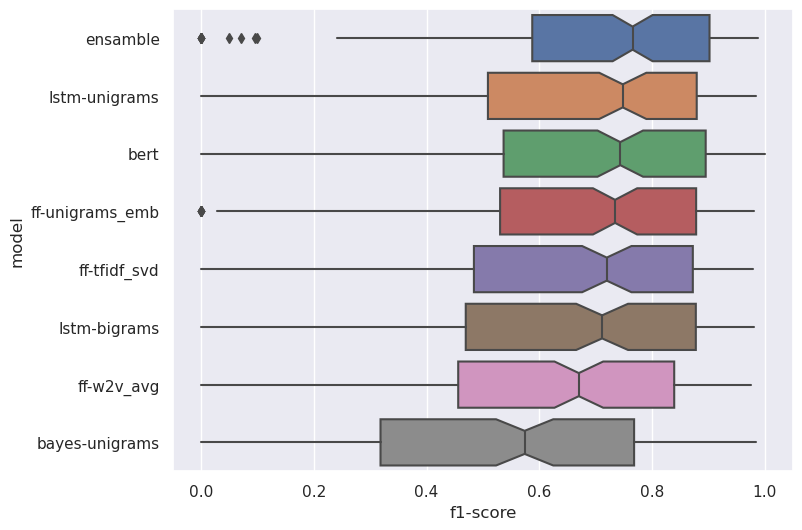

In [17]:
plot_summary(common_report, 'f1-score')

**Observaciones**

- Las distribuciones de todos los modelos, a excepción de **bayers**, estan sesgadas a derecha. 
- Esto no dice que estos modelos tiene a tener un major **f1-score** x clases a diferencia de **bayes** donde no existe esse sesgo.
- Se puede apreciar outliers a izquierda, donde encontraremos clases con valores de **f1-score** atipicamente bajos.

<Figure size 800x600 with 1 Axes>

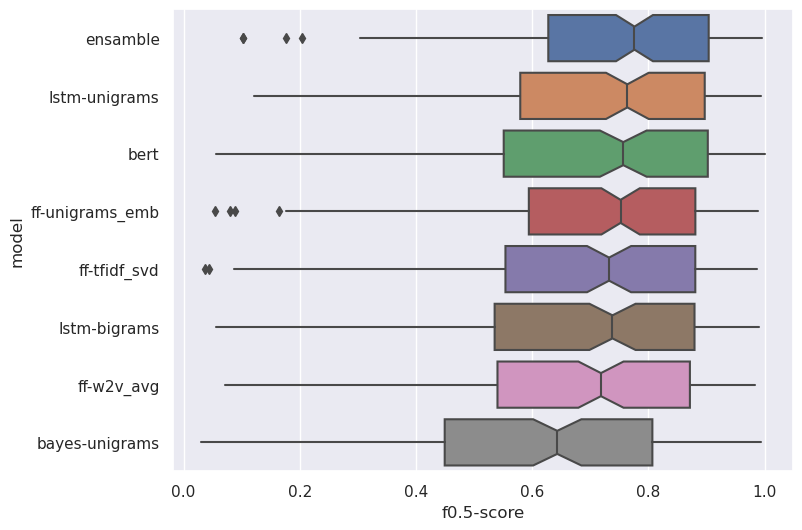

In [18]:
plot_summary(common_report, f'f{BETA}-score')

<Figure size 800x600 with 1 Axes>

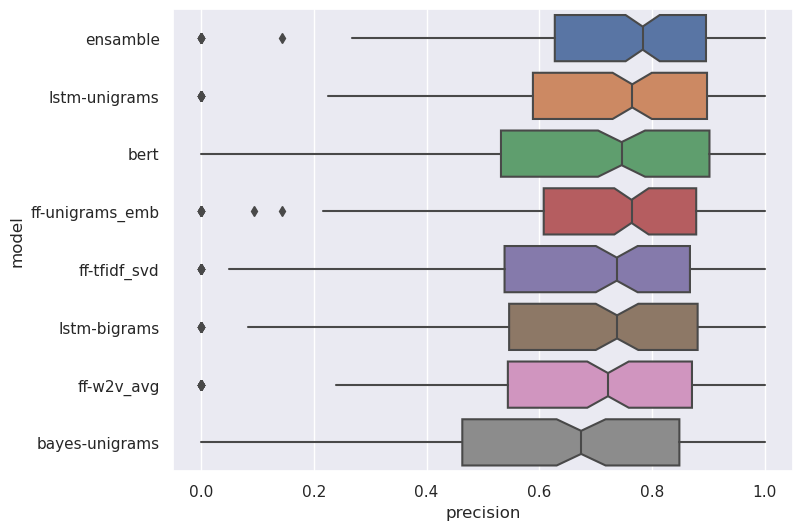

In [19]:
plot_summary(common_report, 'precision')

<Figure size 800x600 with 1 Axes>

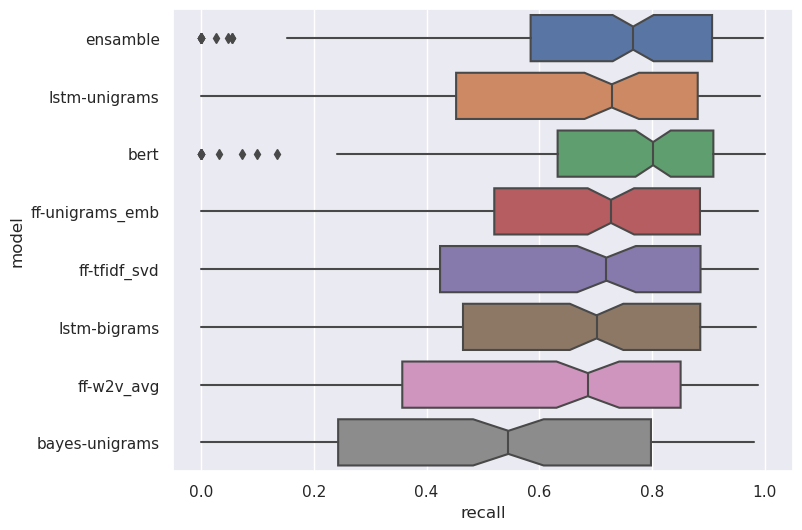

In [20]:
plot_summary(common_report, 'recall')

**Observaciones**

- Al igual que el **f1-score**, el **recall** tiene a estar sesgado a derecha, en todos los casos a excepción de **bayes**.
- **bayes** y **m-embedding-lstm-bid-bigrams** no presentan outliers.

In [21]:
# sns.heatmap(report.corr(), annot=True)

<Figure size 800x600 with 1 Axes>

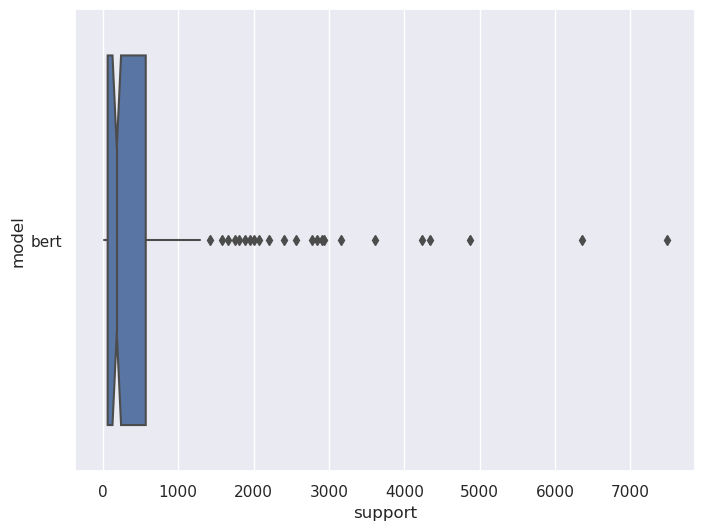

In [22]:
pl.comparative_box_plot(common_report[common_report['model'] == 'bert'], 'support', 'model')

In [23]:
upper_outliers_level(common_report, 'support')

790.5

**Observaciones**

- El soporte por clase esta muy desbalandeado. Esto se debe a la naturaleza desbalanceada de nuestro dominio, donde exsitne pocas calses no mucho productos y muchas con pocos.

### Correlaciones

<Figure size 1428.12x1250 with 20 Axes>

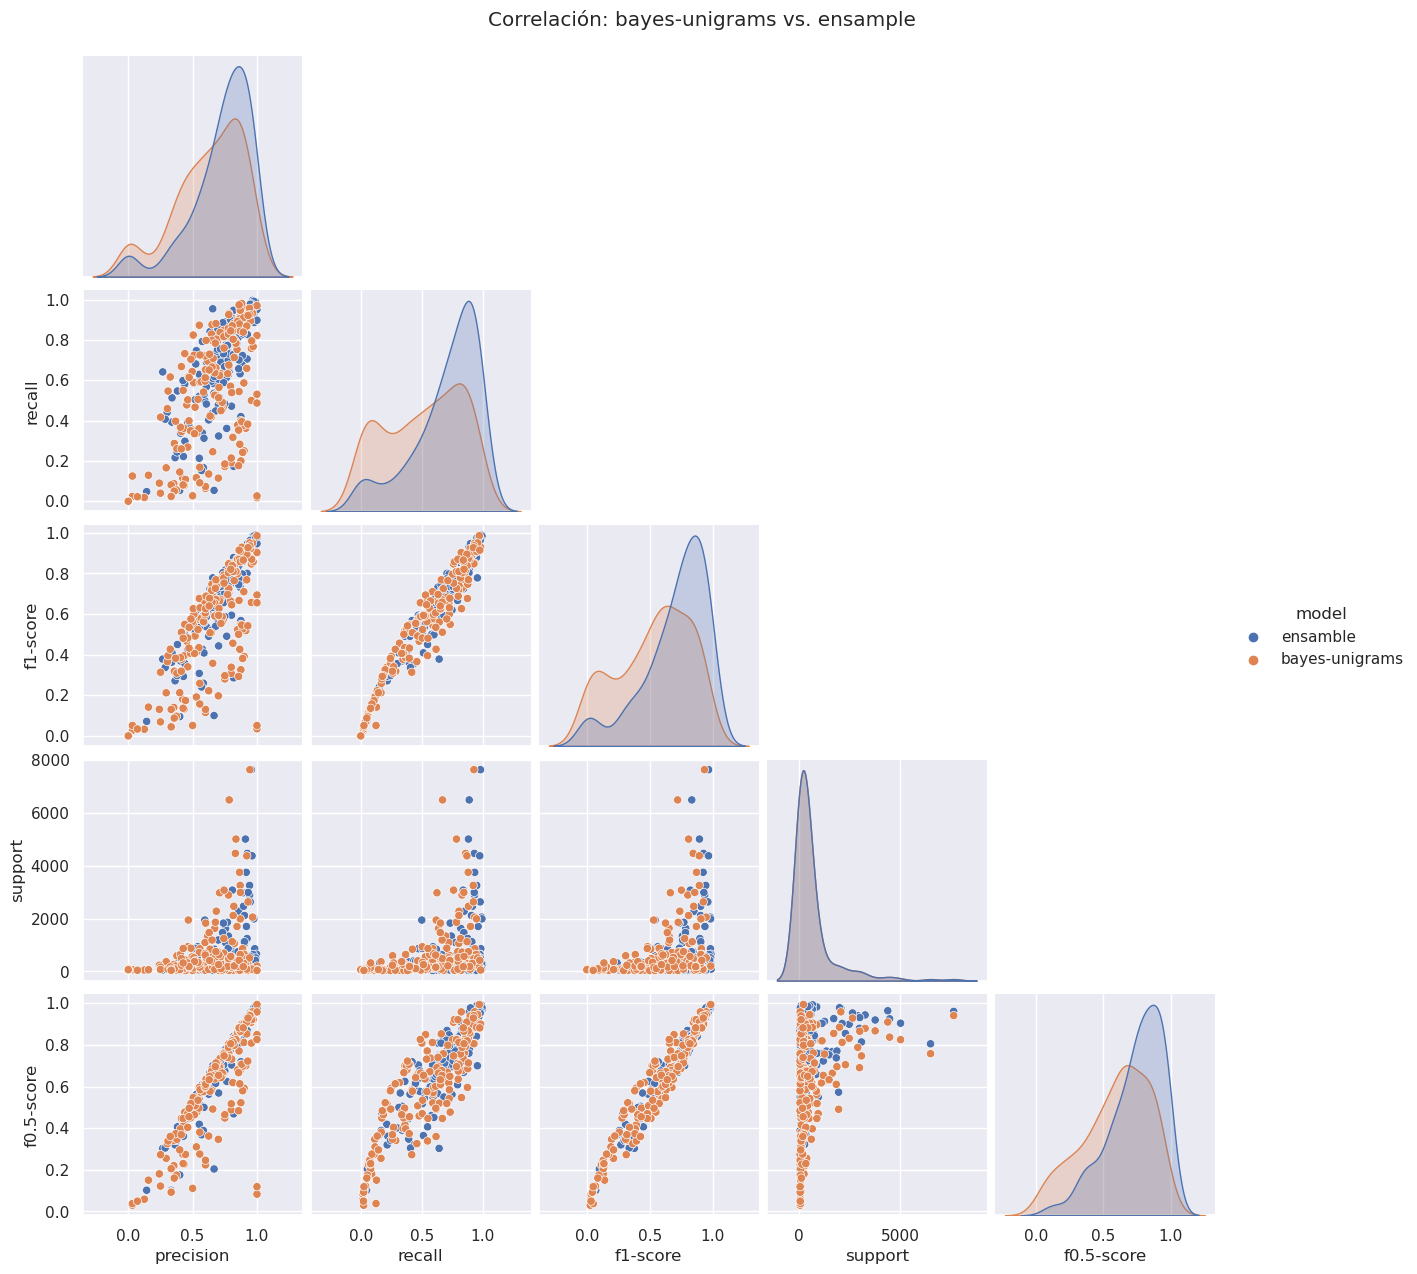

In [24]:
pl.pairplot(
    common_report[common_report['model'].isin(['bayes-unigrams', 'ensamble'])], 
    hue='model', 
    title='Correlación: bayes-unigrams vs. ensample'
)

**Observaciones de distribuciones de f1-score**
 
- En este caso las instancias son las clases que predice el modelo y los valores son los valores que toma el f1-score.
- Las distribuciones del f1-score para ambos modelos esta sesgadad a derecha (En mayor medida para bert). Siempre es deseado que el f1-score sea una distribuciñin sesgadaa a derecha, ya que las clases tiene a tener mayor f1-score.
- La distribucion de bayes acumulan mayor cantidad de clases para valores bajos de f1-score. Lo contrario suceded con bert, donde se puede ver que tiene menores frecuencias para valores bajos de f1-score.
- De esta foram se aprecia que los valores de f1-score tiene a ser mas alto para todas las clases con el modelo bert.

- Es importante destacar el maximo en ambos modelos, donde bayes llega hasta 0.75 y bert esta cercanos a 1. Esto nos dice dos cosas:
  - bert: El f1-score tiene una distribución muy leptocúrtica, es decir alcanza majores valores de f1-score pero el ancho de esta nos dice que no son tantas clases las que que alcanzan esos valores.
  - bayes: Sucede la contario, la distribución tiende a ser menos leptocúrtica pero el pico es mas ancho, lo que no dice que hay un numero major de clases con niveles alto de f1-score pero el maximo mucho mejor al maximo que tiene bayes.


**Observaciones de distribuciones de x=precision/recall, y=f1-score**

- Para el mismo nivel de preicisión, bayes tiene mayor dispersión para cada nivel de f1-score por lo menos en valores manores a 0.75. bert por el contrario tiene meno disperción de f1-score. La mayor dispercion se cuentra en f1-score 0.6.
- En el caso de l recall bert parece tener mayor disperción del f1-score para niveles de recall entre 0.5 y 0.75.
- En ambos casos la precision y el recall tiene un piso mucho mas alto para bert.

<Figure size 1415.75x1250 with 20 Axes>

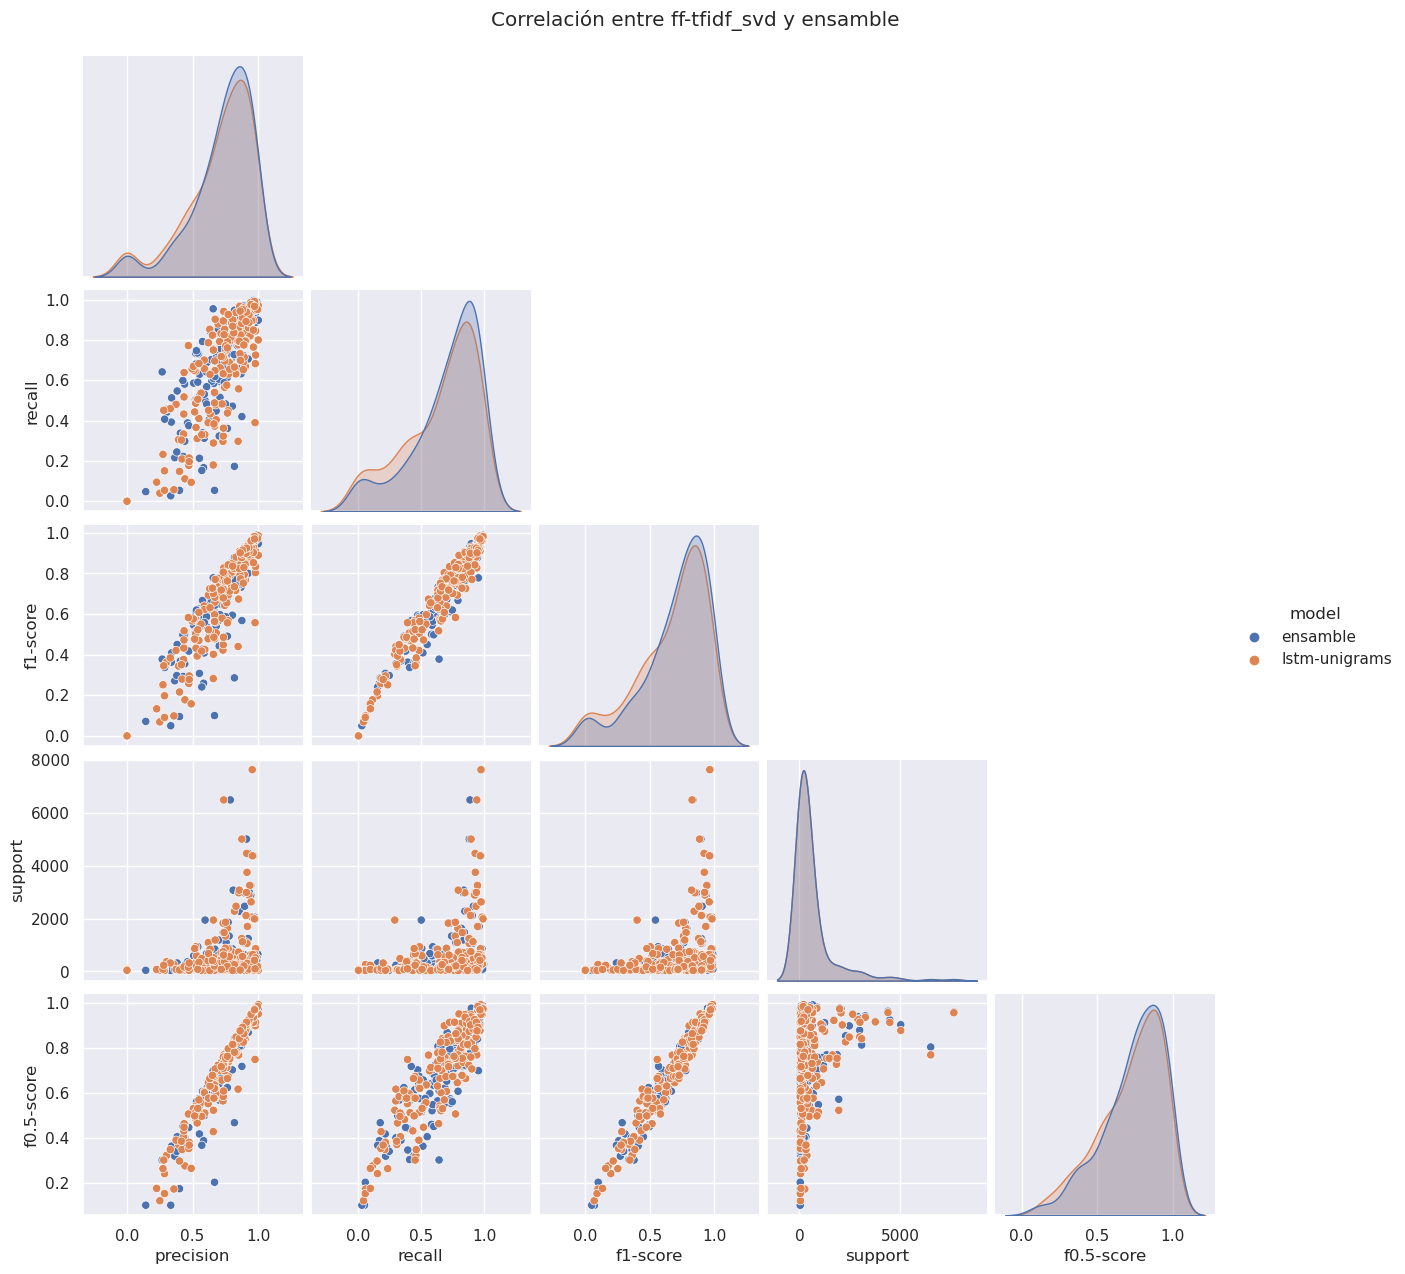

In [36]:
pl.pairplot(
    common_report[common_report['model'].isin(['lstm-unigrams', 'ensamble'])], 
    hue='model', 
    title='Correlación entre ff-tfidf_svd y ensamble'
)

<Figure size 1380x1250 with 20 Axes>

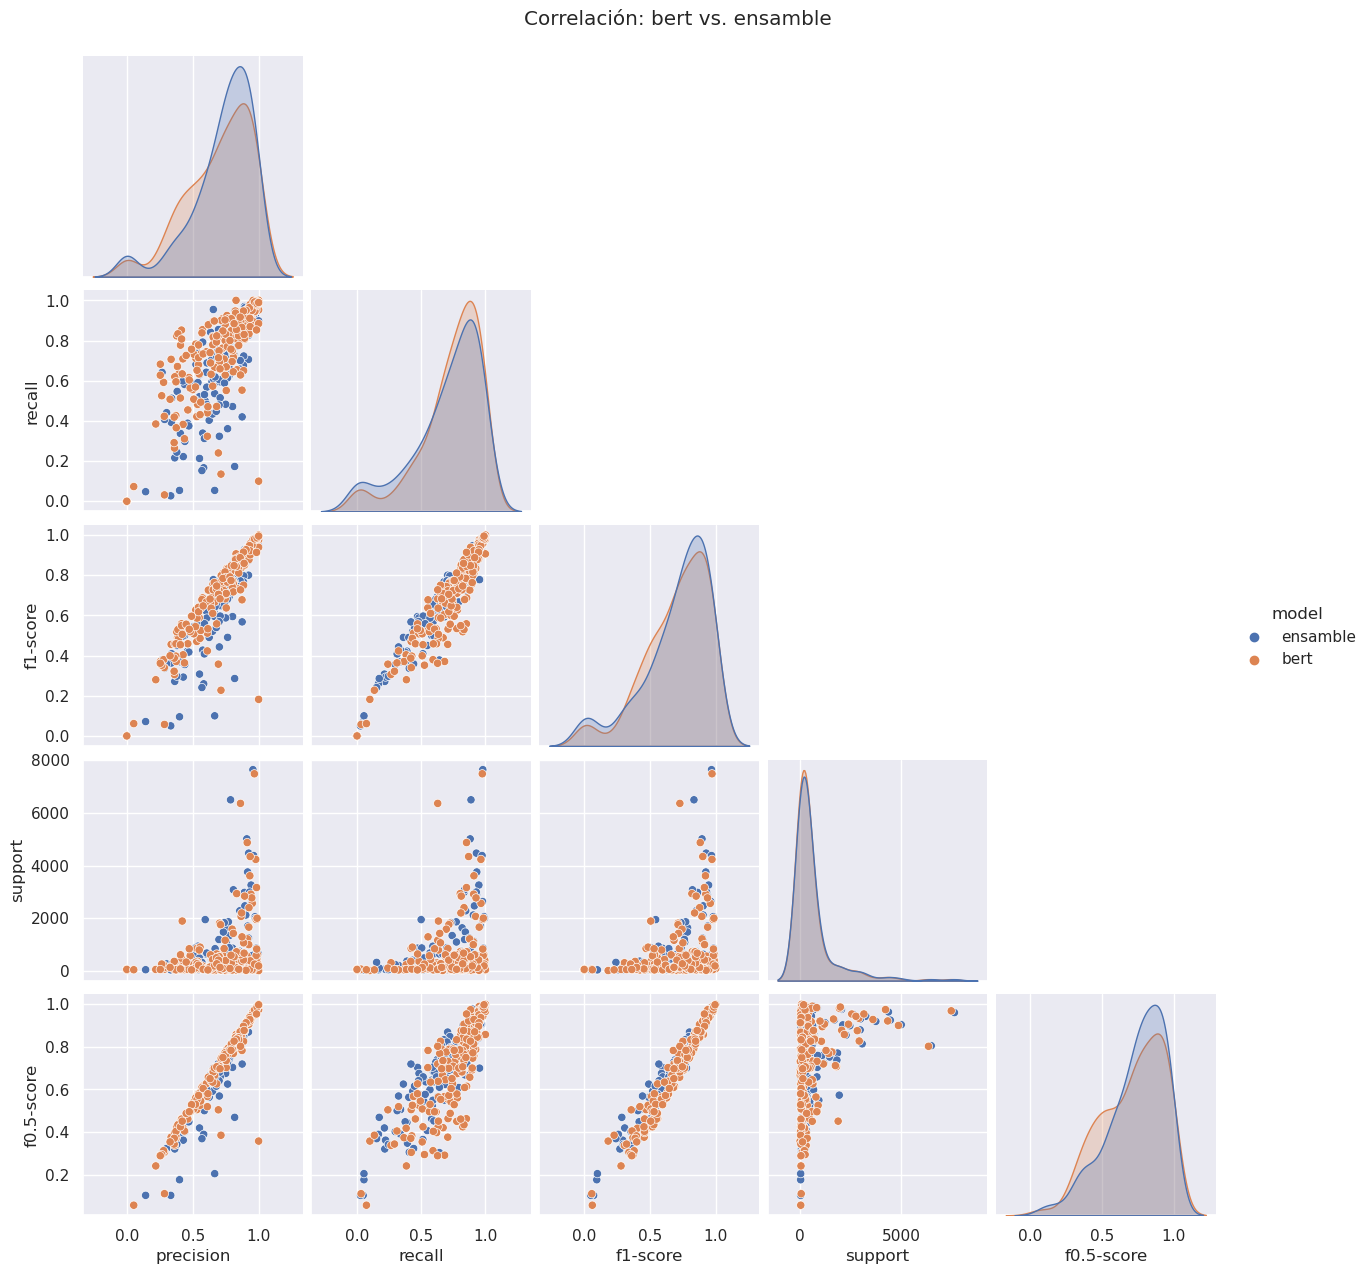

In [32]:
pl.pairplot(
    common_report[common_report['model'].isin(['bert', 'ensamble'])], 
    hue='model', 
    title='Correlación: bert vs. ensamble'
)

<AxesSubplot:xlabel='f1-score', ylabel='Count'>

<Figure size 2000x1000 with 1 Axes>

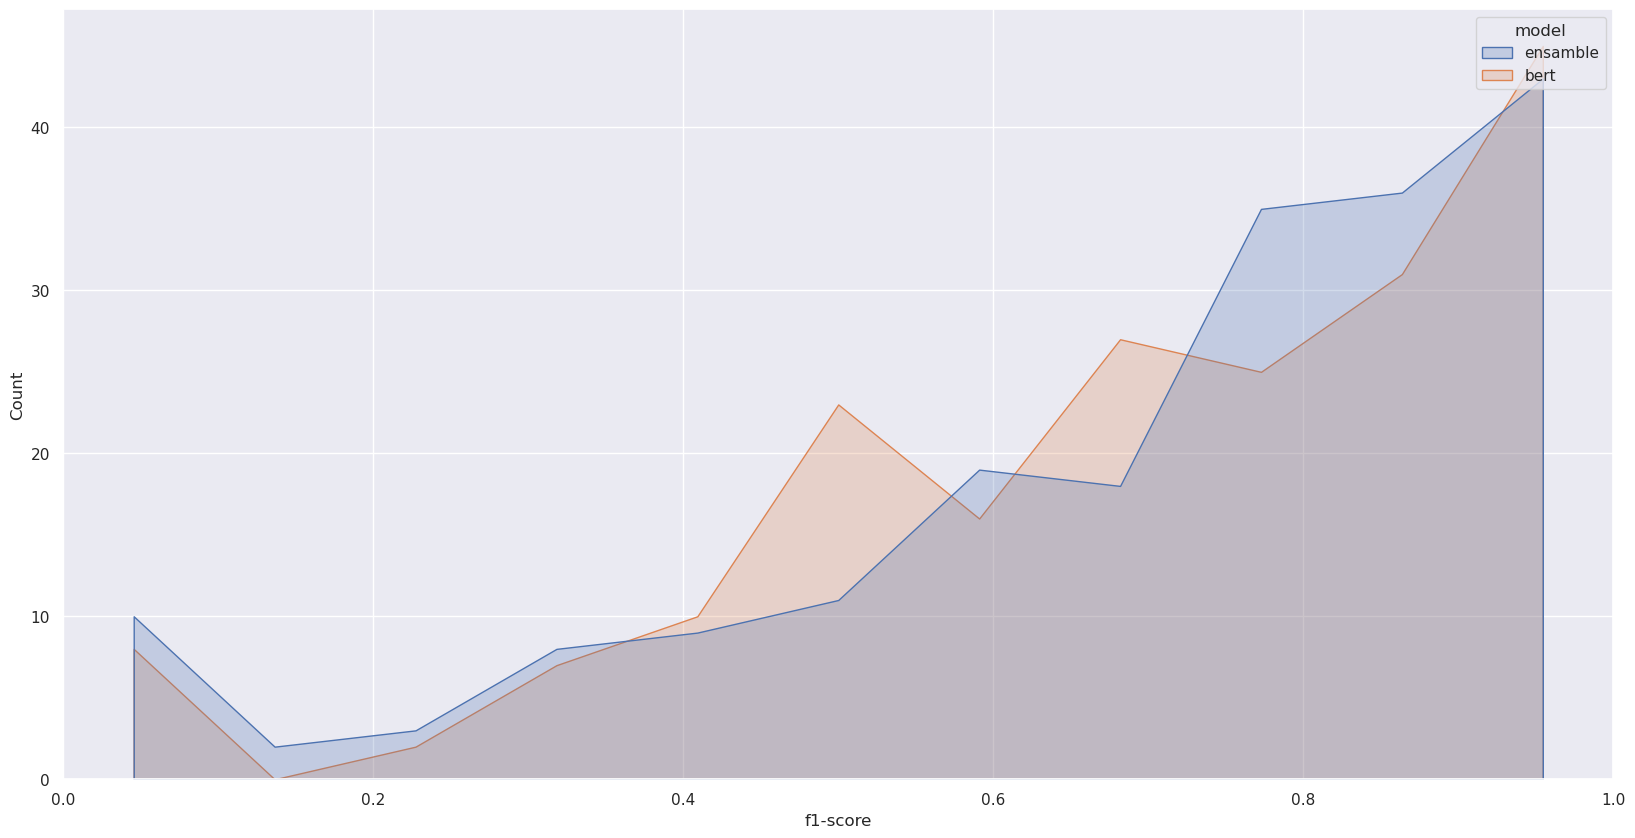

In [33]:
sns.histplot(
    common_report[common_report['model'].isin(['ensamble', 'bert'])],
    x="f1-score",
    hue="model",
    element="poly"
)

<AxesSubplot:xlabel='f1-score', ylabel='Count'>

<Figure size 2000x1000 with 1 Axes>

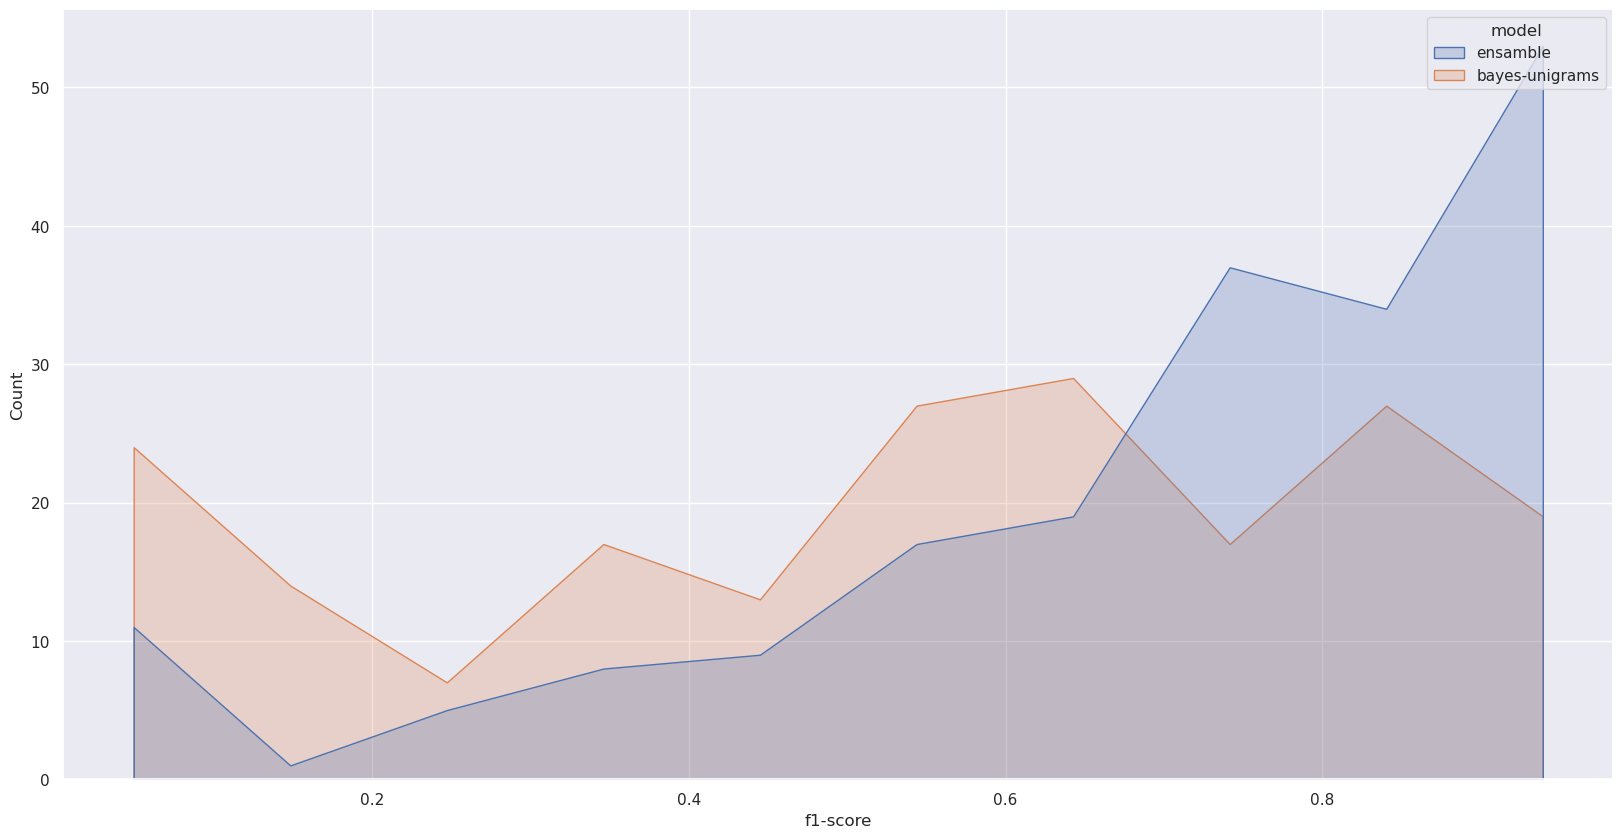

In [34]:
sns.histplot(
    common_report[common_report['model'].isin(['bayes-unigrams', 'ensamble'])],
    x="f1-score",
    hue="model",
    element="poly"
)

<AxesSubplot:xlabel='f1-score', ylabel='Count'>

<Figure size 2000x1000 with 1 Axes>

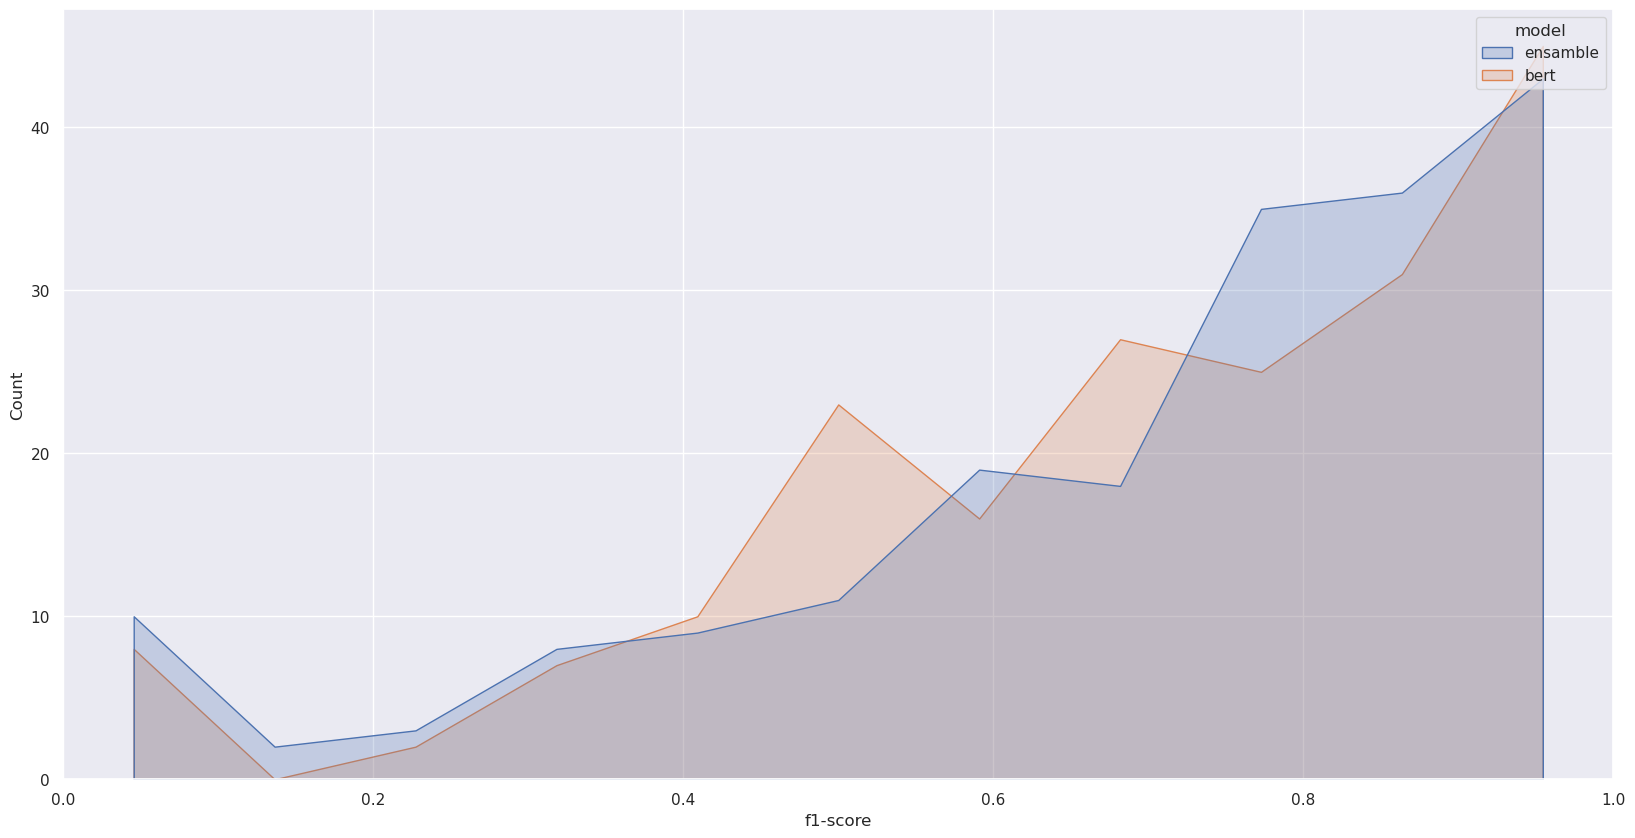

In [35]:
sns.histplot(
    common_report[common_report['model'].isin(['bert', 'ensamble'])],
    x="f1-score",
    hue="model",
    element="poly"
)

In [30]:
https://www.iartificial.net/precision-recall-f1-accuracy-en-clasificacion/

SyntaxError: invalid syntax (3742733787.py, line 1)